>This post was inspired mostly by the arrival of the new Julia package [Literate.jl](https://github.com/fredrikekre/Literate.jl) by Fredrik Ekre. Literate lets you write a Julia source file, a Markdown blog post, and a Jupyter notebook all at the same time. It's magic, or, at least, indistinguishable from magic... As a result, you might be able to find a Jupyter notebook version of this Markdown-converted Julia source file somewhere nearby (look in the [github repo](https://github.com/cormullion/cormullion.github.io) for this blog, perhaps). The code uses the following packages, Literate, Luxor, Colors, Roots, Fontconfig, DataFrames, Iterators, ColorSchemes, and should work in Julia v0.6 (some packages such as Colors have yet to be updated to work with version 0.7).

# Bézier moi!

Luxor provides some support for Bézier curves, but there's no room for any more documentation—it's already too big. So the intention of this post is to provide some of the missing information about what's up with Bézier curves and how you might use them. And I confess in advance to wasting some of your bandwidth with some pointlessly colourful graphics.

There's not a lot of mathematical material here, but fortunately the internet is *awash* with high-quality information about Bézier curves. The two articles you should definitely read instead of this post, or at least before, are:

- [https://pomax.github.io/bezierinfo/](https://pomax.github.io/bezierinfo/)  An exhaustive and exhausting examination of Bézier curves by Mike 'Pomax' Kamermans, Mozilla JavaScript guru, complete with interactive JavaScript graphics.

- [http://mae.engr.ucdavis.edu/~farouki/bernstein.pdf](http://mae.engr.ucdavis.edu/~farouki/bernstein.pdf) A paper exploring the history and mathematics of curves by Professor Rida T. Farouki (University of California Davis).

## Historical background

The story is quite well known: two engineers employed in the French car industry, *Paul de Faget de Casteljau*, at Citroen, and *Pierre Etienne Bézier*, at Renault, worked—mostly independently—on the mathematics of curves in the early 1960s, as the industry made its first tentative steps towards using computers for design and production.

![Citroen DS](notebooks/images/bezier/2560px-Bornholm_Rundt_2012.jpg)

(This is the Citroen DS, which was once voted the most beautiful car ever made, apparently. Image from the WikiMedia Commons photographed by [Klugschnacker](https://commons.wikimedia.org/w/index.php?curid=28638457))

De Casteljau and Bézier were interested in mathematical tools that would allow designers to intuitively construct and manipulate complex shapes. This problem was especially critical for “free–form” shapes that couldn't easily be specified by centre points, axes, angles, and dimensions. The motivation was also partly to replace the laborious, variable, and expensive process of sculpting clay models to specify the desired shape.

De Casteljau found some resistance when his mathematical researches were introduced into the design studio. He observed that:

>the designers were astonished and scandalized. Was it some kind of joke? It was considered nonsense to represent a car body mathematically. It was enough to please the eye, the word 'accuracy' had no meaning. [quoted in Farouki]

Bézier popularized, but did not actually create, what we know today as the Bézier curve. He mainly developed the notation, and devised the idea of nodes with attached "control handles", which the designers could use to adjust the shapes as easily as they used the turn indicators on their beloved Citroen DSs.

De Casteljau is also remembered for the [algorithm](https://en.wikipedia.org/wiki/De_Casteljau%27s_algorithm) that bears his name.

## The shortest distance?

With the lingering thought of old Renaults and Citroens in mind, it's tempting to think of a Bézier curve as a line that takes, not the shortest distance between two points, but takes instead the scenic route.

Let's define four points:

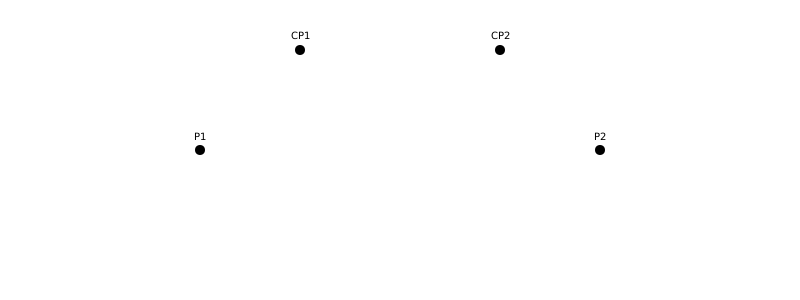

In [1]:
using Luxor
P1  = Point(-200, 0)
CP1 = Point(-100, -100)
CP2 = Point(100, -100)
P2  = Point(200, 0)
@png begin
    circle.([P1, CP1, CP2, P2], 5, :fill)
    label.(["P1", "CP1", "CP2", "P2"], :N, [P1, CP1, CP2, P2], offset=10)
end 800 300 "images/bezier/fourpoints.png"

![four points](notebooks/images/bezier/fourpoints.png)

The first and last points, P1 and P2, are the start and end of the line. The second point, CP1, controls the direction of the line as it leaves the first point, and the third point, CP2, determines the way the line approaches the fourth point. PostScript guru Don Lancaster (see footnote) uses the terms ‘influence point’ and ‘enthusiasm’—so the second influence point determines the enthusiasm with which the curve travels towards its final destination.

The graphics primitive `curve()` function draws a Bézier curve between P1 and P2, taking into account the positions of control points CP1 and CP2. It takes just three points, using the current position as the starting point.

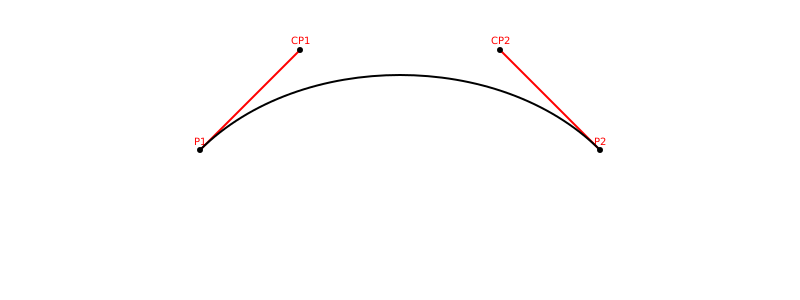

In [2]:
using Colors
@png begin
    sethue("red")
    label.(["P1", "CP1", "CP2", "P2"], :N, [P1, CP1, CP2, P2])
    line(P1, CP1,:stroke)
    line(CP2, P2,:stroke)
    sethue("black")
    move(P1)
    curve(CP1, CP2, P2)
    strokepath()
    circle.([P1, CP1, CP2, P2], 3, :fill)
end 800 300 "images/bezier/curve.png"

![simple bezier curve](notebooks/images/bezier/curve.png)

The control points are like handles, controlling the shape of the curve. If you've used Adobe Illustrator or some other vector graphics software, you'll be familiar with the idea of interactively dragging the handles around to get interesting curves. In Luxor, though, we sacrifice interactivity in favour of ruthless machine-driven automation. In the following animation, the control handles explore the geometry of a couple of hypotrochoids, while the helpless Bézier curve is pinned between them and forced into sinuous contortions:

# ![animation gif](notebooks/images/bezier/animation.gif)

Can I make this in Adobe Illustrator? Hold my beer...

While you're waiting, have a look at another animation; this is my artist's impression of the De Casteljau algorithm dividing the control polygons around a Bézier curve as the parameter `n` moves from 0 to 1. The idea is that as `p1` divides `A` to `A1`, `p2` divides `A1` to `B1` and `p3` divides `B1` to `B`. So, `pp1` divides `p1` to `p2`, and `pp2` divides `p2` to `p3`. And you keep doing this until you can't divide any more, and eventually the point `P` plots the course of the final Bézier curve. The red and blue parts of the curve show that this technique is also a good way to split a single Bézier curve into two separate ones, and the red and blue parts are separate control polygons.

![De Casteljau](notebooks/images/bezier/decasteljau.gif)

In Luxor, a `BezierPathSegment` type contains four 2D points, stored in the fields `p1`, `cp1`, `cp2`, and `p2`, and a `BezierPath` is an array of one or more of these BezierPathSegments. The `drawbezierpath()` function draws a BezierPath or BezierPathSegment, with similar results to the `curve()` function:

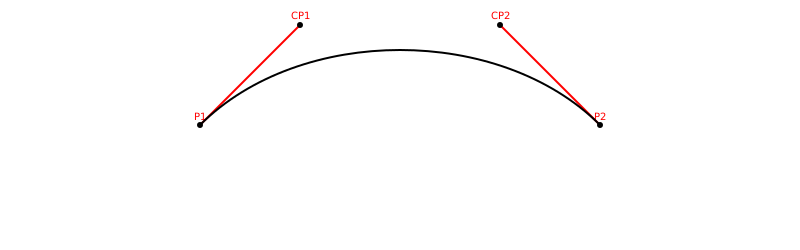

In [3]:
@png begin
    P1  = Point(-200, 0)
    CP1 = Point(-100, -100)
    CP2 = Point(100, -100)
    P2  = Point(200, 0)

    sethue("red")
    label.(["P1", "CP1", "CP2", "P2"], :N, [P1, CP1, CP2, P2])
    line(P1, CP1,:stroke)
    line(P2, CP2,:stroke)
    sethue("black")

    beziersegment = BezierPathSegment(P1, CP1, CP2, P2)
    circle.(beziersegment, 3, :fill)
    drawbezierpath(beziersegment, :stroke)
end 800 250 "images/bezier/drawbezierpath.png"

![draw a Bezier path](notebooks/images/bezier/drawbezierpath.png)

This last function, `drawbezierpath()` is a typical Luxor drawing function, in that you can provide `:fill` as an alternative action to `:stroke`.

An easy way to make a BezierPath is to use `makebezierpath()` and supply a polygon. For example, let's make a triangle with `ngon()` and use it as the skeleton for a new Bézier path:

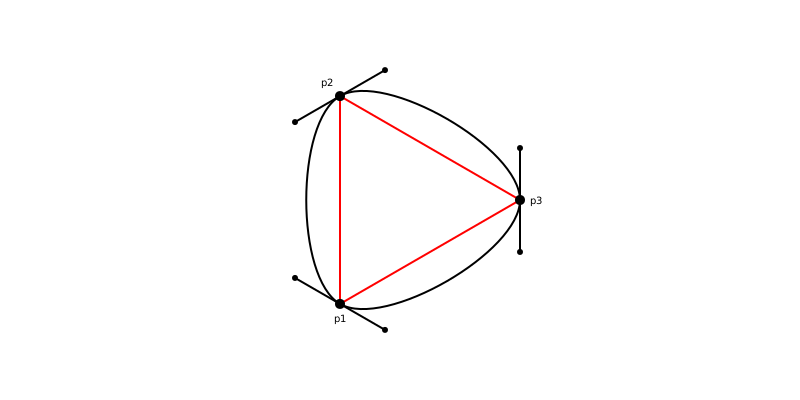

In [4]:
@png begin
    sethue("red")
    triangle = ngon(O, 120, 3, vertices=true)
    poly(triangle, :stroke, close=true)

    sethue("black")
    bezierpath = makebezierpath(triangle)
    drawbezierpath(bezierpath, :stroke)
    circle.(triangle, 5, :fill)

    for bps in bezierpath
        circle.(bps, 3, :fill)
        line(bps[1], bps[2], :stroke)
        line(bps[3], bps[4], :stroke)
    end

    label.(["p1", "p2", "p3"], [:S, :NW, :E], triangle, offset=10)
end 800 400 "images/bezier/makebezierpath.png"

![make bezier path](notebooks/images/bezier/makebezierpath.png)

Here `makebezierpath()` converted the three points into an array of three separate Bézier path segments. The control points are positioned so that the curve flows freely from one segment to the segment.

## Going straight

Bézier curves can have straight bits too. This animation shows the control points moving towards the points they're controlling. When they merge, the Bézier path appears to become a series of straight lines:

In [5]:
function frame(scene, framenumber)
    background("white")
    eased_n = scene.easingfunction(framenumber, 0, 1, scene.framerange.stop)
    sethue("red")
    triangle = ngon(O, 120, 3, vertices=true)
    poly(triangle, :stroke, close=true)
    sethue("black")
    bezierpath = makebezierpath(triangle)
    newbezierpath = BezierPath()
    for bps in bezierpath
        push!(newbezierpath,
            BezierPathSegment(bps.p1,
             between(bps.cp1, bps.p1, eased_n),
             between(bps.cp2, bps.p2, eased_n),
             bps.p2))
    end
    for bps in newbezierpath
        circle.(bps, 3, :fill)
        line(bps.p1, bps.cp1, :stroke)
        line(bps.cp2, bps.p2, :stroke)
    end
    drawbezierpath(newbezierpath, :stroke)
end

width, height = (256, 256)

bedtimemovie = Movie(width, height, "bedtimemovie")
# probably requires ffmpeg installed
animate(bedtimemovie, [Scene(bedtimemovie, frame, 1:150, easingfunction=easeoutquad)], creategif=true, framerate=30, pathname="images/bezier/bedtimemovie.gif")

┌ Info: Frames for animation "bedtimemovie" are being stored in directory: 
│ 	 /tmp/jl_14DuJN
└ @ Luxor /home/kdb/.julia/packages/Luxor/Sjhki/src/animate.jl:177
┌ Warning: Movie framerange is longer than scene frame range: 
│ 	 1:250 > 150
└ @ Luxor /home/kdb/.julia/packages/Luxor/Sjhki/src/animate.jl:185
┌ Info: ... 150 frames saved in directory:
│ 	 /tmp/jl_14DuJN
└ @ Luxor /home/kdb/.julia/packages/Luxor/Sjhki/src/animate.jl:199
┌ Info: GIF is: images/bezier/bedtimemovie.gif
└ @ Luxor /home/kdb/.julia/packages/Luxor/Sjhki/src/animate.jl:216


Luxor.AnimatedGif("images/bezier/bedtimemovie.gif")

# ![bedtime for Béziers](notebooks/images/bezier/bedtimemovie.gif)

This is a process known to very young Adobe Illustrator users as ‘putting the Bézier handles to bed’.

It's also fun to move the control points somewhere else. Here, they're multiplied by 2, while the first and last points are left unchanged:

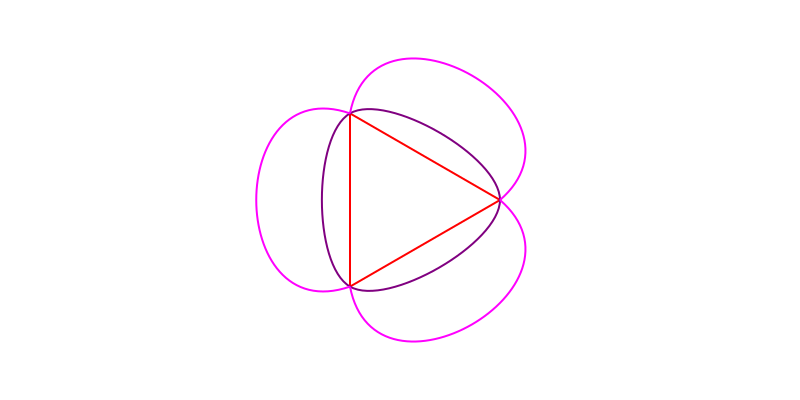

In [6]:
@png begin
    sethue("red")
    triangle = ngon(O, 100, 3, vertices=true)
    poly(triangle, :stroke, close=true)

    sethue("purple")
    bezierpath = makebezierpath(triangle)
    drawbezierpath(bezierpath, :stroke)
    sethue("magenta")
    for bps in bezierpath
        bps = BezierPathSegment(bps[1], 2bps[2], 2bps[3], bps[4])
        drawbezierpath(bps, :stroke)
    end

end 800 400 "images/bezier/movecontrolpoints.png"

![moving control points](notebooks/images/bezier/movecontrolpoints.png)

We could make even more copies, multiplying the control points each time through:

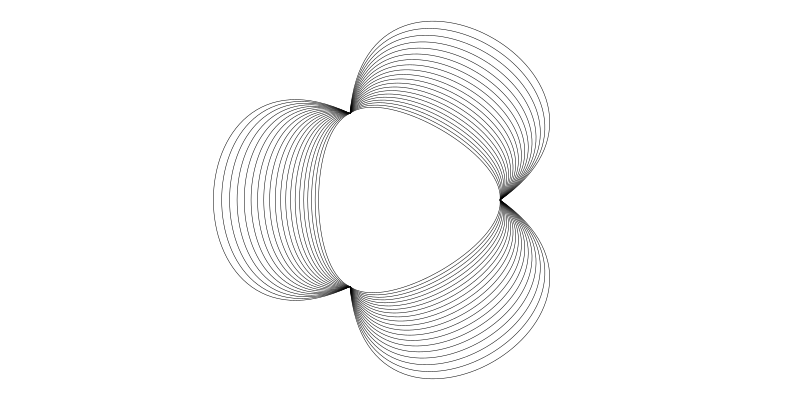

In [7]:
@png begin
    setline(.5)
    pgon = ngon(O, 100, 3, vertices=true)
    bezierpath = makebezierpath(pgon)

    for bpseg in bezierpath
        for i in 1:20
            bpseg.cp1 *= 1.05
            bpseg.cp2 *= 1.05
            drawbezierpath(bpseg, :stroke)
        end
    end
end 800 400 "images/bezier/movecontrolpointsmore.png"

![moving multiple control points](notebooks/images/bezier/movecontrolpointsmore.png)

Try changing the initial triangle to a pentagon or heptagon by changing the `3` in `ngon()`. And try multiplying by less than 1.05 too...

Should you ever want to draw Bézier curves "the hard way", try this. The standard Bézier function is available in Luxor as `bezier()`, and we could draw a small hue-varying circle at each point:

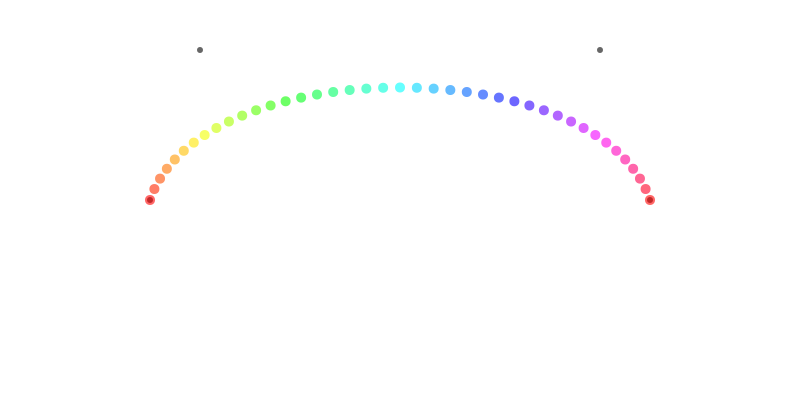

In [8]:
@png begin
    setopacity(0.6)
    P1  = Point(-250, 0)
    CP1 = Point(-200, -150)
    CP2 = Point(200, -150)
    P2  = Point(250, 0)
    circle.([P1, CP1, CP2, P2], 3, :fill)

    for u in 0.0:0.025:1.0
        sethue(Colors.HSV(rescale(u, 0, 1, 0, 360), 1, 1))
        pt = bezier(u, P1, CP1, CP2, P2)
        circle(pt, 5, :fill)
    end

end 800 400 "images/bezier/thehardway.png"

![bezier the hard way](notebooks/images/bezier/thehardway.png)

What happens if you step `u` from say, -25.0 to 25.0? And is that supposed to happen? (Spoiler: the curve doubles back and shoots off to `(±∞/∞)`.)

## Out of control

Suppose you wanted to draw a Bézier curve but you didn't know where the control points were, but you did know a couple of points that should lie on the line? Again, Luxor has the answer for you, in the form of a function called `bezierfrompoints()`. You supply four points, and the function returns the points of the Bézier curve that passes through them.

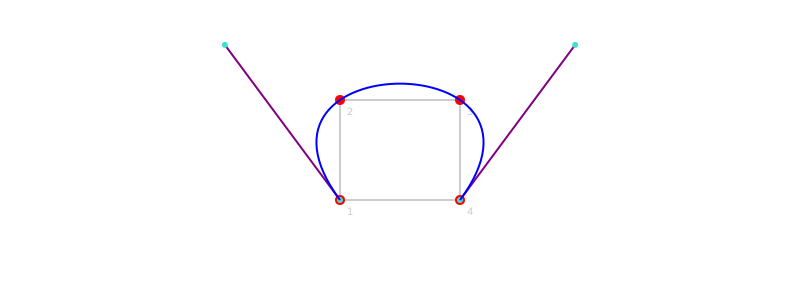

In [9]:
@png begin
    sethue("grey80")
    box(O, 120, 100, :stroke)
    corners = box(O, 120, 100, vertices=true)
    label.(["1", "2","3", "4"], :se, corners, offset=10)
    sethue("red")
    circle.(corners, 5, :fill)

    startpoint, cp1, cp2, endpoint  = bezierfrompoints(corners...)

    sethue("purple")
    line(startpoint, cp1, :stroke)
    line(endpoint, cp2, :stroke)

    sethue("turquoise")
    circle.([cp1, cp2, startpoint, endpoint], 3, :fill)

    sethue("blue")
    drawbezierpath(BezierPathSegment(startpoint, cp1, cp2, endpoint), :stroke)
end 800 300 "images/bezier/bezierfrompoints.png"

![bezier through four points](notebooks/images/bezier/bezierfrompoints.png)

Note that this function returns all four points, but of course you already knew the first and last ones (in `corners`), you just wanted the two control points.

## On the right path?

In Luxor the three main ways to make graphic lines and shapes are: *paths*, *polygons*, and *BezierPaths*. Paths are the fundamental building blocks of graphics, consisting of one or more sequences of straight and Bézier curves. A polygon is an array of points, which will be converted to a path when you draw it. And BezierPaths consist of a list of BezierPathSegments, which will also be converted to ordinary paths when they're drawn.

It's useful to be able to convert between the different types:

|   Function                                   |  Converts                                   |
|-----------------------------                 | ------------------------------------------- |
|   `makebezierpath(pgon)`                     |  polygon to BezierPath                      |
|   `pathtopoly()`                             |  current path to array of polygons          |
|   `pathtobezierpaths()`                      |  current path to array of BezierPaths       |
|   `beziertopoly(bpseg)`                      |  BezierPathSegment to polygon               |
|   `bezierpathtopoly(bezierpath)`             |  BezierPath to polygon                      |
|   `bezierfrompoints(p1, p2, p3, p4)`         |  convert four points to BezierPathSegment   |

## Can't draw a circle?

Having witnessed the ability of a simple Bézier curve to adopt so many shapes, it's a bit surprising to find out that you can't use a Bézier curve to draw a circle. Well, it can do a very good impression of one, of course, but mathematically it can't produce a purely circular curve. You can see this if you draw a *very* large circle and a *very* large matching Bézier segment. For a circle with radius 10 meters (and that's one big PDF), the discrepancy between the pure circle and the Bézier approximation isn't much bigger than the size of this period/full stop.←

We non-scientists are lucky in not having to worry about errors of this magnitude...

# ![a 10 metre circle](notebooks/images/bezier/10metrecircle.png)

In the above picture, the red circle is made by `circle()`, the green one is made with Bézier curves (as used by `circlepath()` and `ellipse()`).

## “0.55228474983 is the magic number”

To draw approximate circles using Bézier curves, you need to know the magic number, usually called *kappa*, which has the value 0.552284.... We're looking at a Bézier curve pretending to be a circular quadrant, with control points positioned at a certain distance kappa from the end points. But how far? What value of kappa—what length of handle—will give us the most circular curve?

A picture of the problem, using a deliberately not-very-good guess at a value for *kappa* of 0.5:

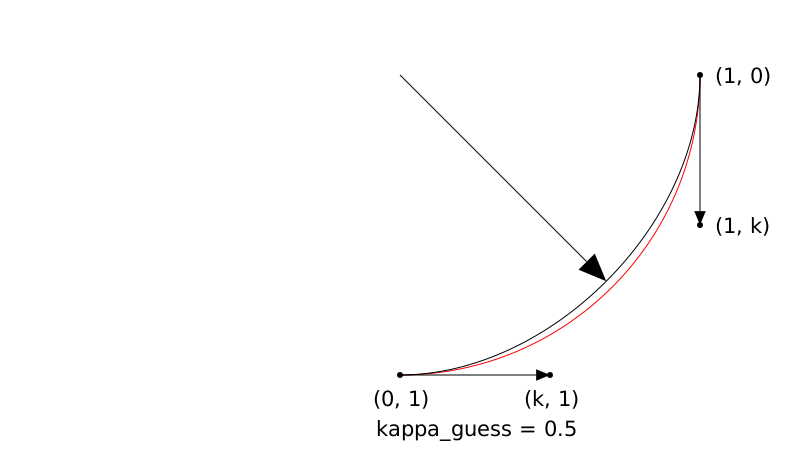

In [10]:
@png begin
    scale(3)
    fontsize(7)
    translate(0, -50)
    setline(1)

    radius = 100

    kappa_guess = .5

    sethue("red")
    arc(O, radius, 0, pi/2, :stroke)

    sethue("black")
    quadrant = BezierPathSegment(
        Point(0, radius),
        Point(kappa_guess * radius, radius),
        Point(radius, kappa_guess * radius),
        Point(radius, 0))
    circle.(quadrant, 1, :fill)
    arrow(quadrant.p1, quadrant.cp1, arrowheadlength=5)
    arrow(quadrant.p2, quadrant.cp2, arrowheadlength=5)

    drawbezierpath(quadrant, :stroke)

    arrow(O, bezier(0.5, quadrant...))

    label.(["(0, 1)", "(k, 1)", "(1, k)", "(1, 0)"], [:S, :S, :E, :E], quadrant)
    label("kappa_guess = 0.5", :S, midpoint(quadrant.p1, quadrant.cp1), offset=15)
end 800 450 "images/bezier/kappaguess.png"

![guessing at kappa](notebooks/images/bezier/kappaguess.png)

To solve this, we'll define a function that takes a value for `kappa` and works out the radius at the center of the Bézier curve.

In [11]:
_radiusofbezier(κ) = distance(O,
    bezier(0.5, BezierPathSegment(
        Point(0, 1),
        Point(κ * 1, 1),
        Point(1, κ * 1),
        Point(1, 0)
        )...))

radiusofbezier(x) = _radiusofbezier(x) - 1

radiusofbezier (generic function with 1 method)

And we'll use one of the many excellent packages in [JuliaMath](https://github.com/JuliaMath/), Roots.jl, to find the zero point:

In [12]:
using Roots
find_zero(radiusofbezier, (0, 1), verbose=true)

LoadError: ArgumentError: Package Roots not found in current path:
- Run `import Pkg; Pkg.add("Roots")` to install the Roots package.


So that's `kappa`.

Alternatively, we can use algebraic sorcery and the parametric equation for the Bézier cubic function to conjure the value from the following incantations:

$$
 \begin{equation}
 \mathbf{p1} = (0, 1)                                                                                               \\\
 \mathbf{cp1} = (k, 1)                                                                                              \\\
 \mathbf{cp2} = (1, k)                                                                                              \\\
 \mathbf{p2} = (1, 0)                                                                                               \\\
 B(u) = \mathbf{p1}(1 - u)³ + \mathbf{cp1} 3u(1 - u)² + \mathbf{cp2}3u²(1 - u) + \mathbf{p2} u³ \\\
 u = 0.5                                                                                                            \\\
\sqrt{0.5}  = \frac{\mathbf{p1}}{8} + \frac{3\mathbf{cp1}}{8} + \frac{3\mathbf{cp2}}{8} + \frac{\mathbf{p2}}{}      \\\
x: \sqrt{0.5}  = \frac{0}{8} + \frac{3 k}{8} + \frac{3}{8} + \frac{1}{8}                                            \\\
y: \sqrt{0.5}  = \frac{1}{8} + \frac{3 }{8} + \frac{3 k}{8} + \frac{0}{8}                                           \\\
\frac{\sqrt{2}}{2} = 3  \frac{k}{8} + \frac{4}{8}                                                                   \\\
\sqrt{2} = 3  \frac{k}{4} + \frac{4}{4}                                                                             \\\
 \sqrt{2} = 3  \frac{k}{4} + 1                                                                                      \\\
 \sqrt{2} - 1 = 3  \frac{k}{4}                                                                                      \\\
3 k  = 4  (\sqrt{2} - 1)                                                                                            \\\
k = \frac{4}{3}  (\sqrt{2} - 1)                                                                                     \\\
k = 0.5522847498307936                                                                                              \\\
\end{equation}
$$

I suspect most applications simply hard-code the magic number 0.552284... directly.

The following code shows how we could animate the process of changing the length of the handles by changing the value of kappa. Blink and you'll miss the sweet spot, though, and the movement of the handles is imperceptible, so perhaps this isn't the best way of illustrating the construction.

In [13]:
function frame(scene, framenumber)
    background("white")
    eased_n = scene.easingfunction(framenumber, 0, 1, scene.framerange.stop)

    radius = 250
    setline(1)
    sethue("black")
    kappa = rescale(eased_n, 0, 1, 0.525, 0.575)

    handlelength = (radius/2)  * kappa

    left   = Point(-radius/2, 0)
    top    = Point(0,        -radius/2)
    right  = Point(radius/2,  0)
    bottom = Point(0,         radius/2)

    line(left, left + (0, -handlelength), :stroke)
    line(top + (-handlelength, 0), top, :stroke)
    circle.([left, top, right, bottom], 2, :fill)
    circle.([left + (0, -handlelength), top + (-handlelength, 0)], 2, :fill)

    line(left, left + (0, -handlelength), :stroke)
    line(top + (-handlelength, 0), top, :stroke)
    circle.([left, top, right, bottom], 2, :fill)
    circle.([left + (0, -handlelength), top + (-handlelength, 0)], 2, :fill)

    move(left)
    curve(left   + (0, -handlelength),
          top    + (-handlelength, 0),
          top)
    curve(top    + (handlelength, 0),
          right  + (0, -handlelength),
          right)
    curve(right  + (0, handlelength),
          bottom + (handlelength, 0),
          bottom)
    curve(bottom + (-handlelength, 0),
          left   + (0, handlelength),
          left)

    if isapprox(kappa, 0.55228, atol=0.001)
        sethue("red")
        fillpath()
        sethue("black")
    else
        strokepath()
    end
    fontface("Menlo")
    fontsize(20)
    text(string(round(kappa, digits=4)), halign=:center)
end
width, height = (400, 400)
circlefrombezier = Movie(width, height, "circlefrombezier")
animate(circlefrombezier, [Scene(circlefrombezier, frame, 1:150, easingfunction=easeoutquad)], creategif=true, framerate=30, pathname="images/bezier/circlefrombezier.gif")

┌ Info: Frames for animation "circlefrombezier" are being stored in directory: 
│ 	 /tmp/jl_Q0c4hL
└ @ Luxor /home/kdb/.julia/packages/Luxor/Sjhki/src/animate.jl:177
┌ Warning: Movie framerange is longer than scene frame range: 
│ 	 1:250 > 150
└ @ Luxor /home/kdb/.julia/packages/Luxor/Sjhki/src/animate.jl:185
┌ Info: ... 150 frames saved in directory:
│ 	 /tmp/jl_Q0c4hL
└ @ Luxor /home/kdb/.julia/packages/Luxor/Sjhki/src/animate.jl:199
┌ Info: GIF is: images/bezier/circlefrombezier.gif
└ @ Luxor /home/kdb/.julia/packages/Luxor/Sjhki/src/animate.jl:216


Luxor.AnimatedGif("images/bezier/circlefrombezier.gif")

# ![kappa value animation](notebooks/images/bezier/circlefrombezier.gif)

Luxor already provides a `Luxor.circlepath()` function that uses four Bézier curve segments to build a path that draws a circle. The main advantage of using this instead of the default `arc`-based circle is that it's easier to build circles with holes:

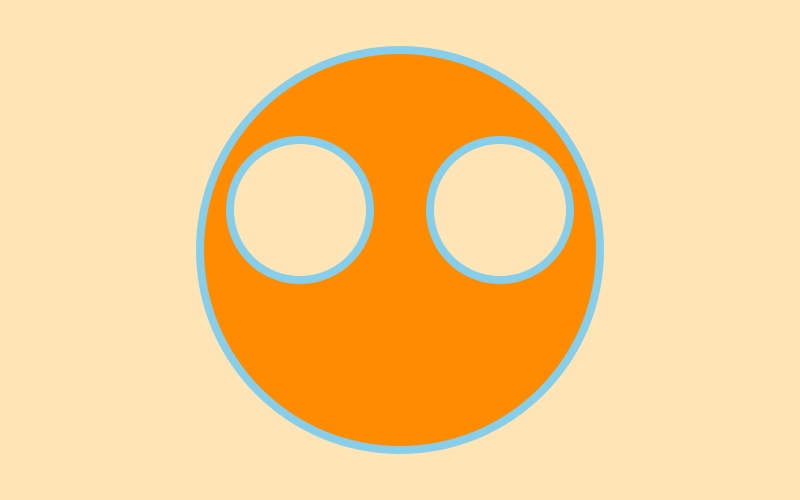

In [14]:
@png begin
    background("moccasin")
    sethue("darkorange")
    circlepath(O, 200, :path)

    newsubpath()
    circlepath(O + (100, -40), 70, :path, reversepath=true)

    newsubpath()
    circlepath(O - (100, 40), 70, :path, reversepath=true)

    fillpreserve()
    setline(8)
    sethue("skyblue")
    strokepath()
end 800 500 "images/bezier/circularpaths.png"

![circular paths](notebooks/images/bezier/circularpaths.png)

## Detour into Typomania

In practice, not being able to draw perfect circles with Bezier curves isn't a big problem. Font designers (you knew this was going to go ‘all typographical’ sooner or later) are big users of Bézier curves, and typically they don't like drawing perfect circles anyway, because of the optical corrections required to make things ‘look right’.

There are a number of optical illusions that demonstrate that the human eye and the brain don't always see reality accurately. The following is one of the simplest, but most people would be prepared to bet that the horizontal bar is thicker and shorter than the vertical bar. I had to draw a grid to double-check...

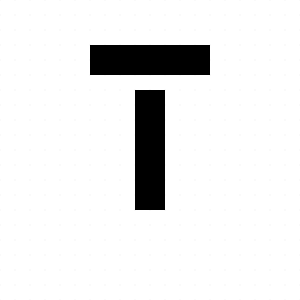

In [15]:
@png begin
    background("white")

    sethue("gray90")
    g = GridRect(BoundingBox()[1], 15, 15, 30 * 20, 30 * 20)
    for i in 1:1600
        circle(nextgridpoint(g), 0.5, :fill)
    end

    b = box(O - (15, -60), O + (15, -60), vertices=true)

    sethue("black")
    poly(b, :fill)
    translate(0, -90)
    rotate(pi/2)
    poly(b, :fill)

end 300 300 "images/bezier/opticalillusion.png"

![simple illusion](notebooks/images/bezier/opticalillusion.png)

It's something to do with how our eyes, set side by side and trained to move side to side horizontally with great speed and precision, underestimate width. Type designers spend much of their time adjusting the relative widths and thicknesses of letter shapes so that illusions like this are compensated for in advance. What happens if you turn your display on its side (apart from possibly spilling your coffee)?

Here's a short script to examine the bounding boxes of the inner and outer loops of the letter ‘o’ in various fonts.

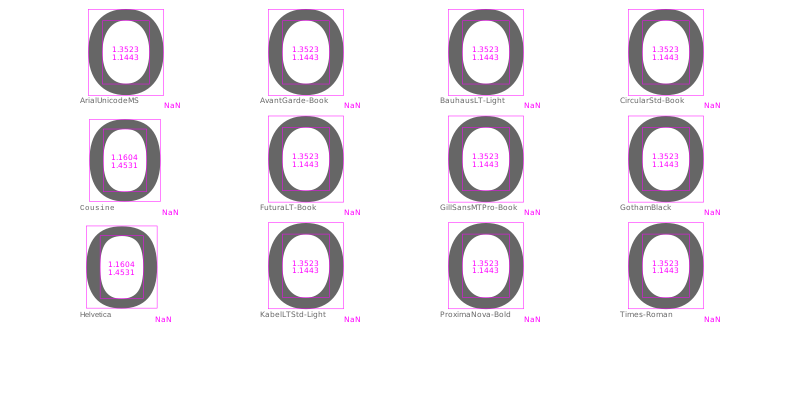

In [16]:
function drawletteraspect(pos, font, thefontsize, str)
    @layer begin
        translate(pos)
        translate(-thefontsize/3, 0)
        fontsize(thefontsize)
        fontface(font)
        sethue("gray40")
        setline(0.5)
        text(str)
        newpath()
        textpath(str)
        o = pathtopoly()
        @layer begin
            fontsize(thefontsize/20)
            text(font, Point(0, thefontsize/15))
            sethue("magenta")
            fontface("Cousine-Bold")
            n = 0
            for i in o
                b = BoundingBox(i)
                text(string(round(boxaspectratio(b), digits = 4)), midpoint(b...) + (0, n), halign=:center)
                n += thefontsize/20
                box(b, :stroke)
            end
        end
    end
end

@png begin
    fonts = [
        "ArialUnicodeMS",
        "AvantGarde-Book",
        "BauhausLT-Light",
        "CircularStd-Book",
        "Cousine",
        "FuturaLT-Book",
        "GillSansMTPro-Book",
        "GothamBlack",
        "Helvetica",
        "KabelLTStd-Light",
        "ProximaNova-Bold",
        "Times-Roman",
    ]
    tiles = Tiler(800, 400, 3, 4, margin=40)
    for (pos, n) in tiles
        drawletteraspect(pos, fonts[mod1(n, length(fonts))], 150, "o")
    end
end 800 400 "images/bezier/drawletteraspect.png"

![aspect ratios of letter O](notebooks/images/bezier/drawletteraspect.png)

The fonts on your system will be different, of course.

## The story of “o”

I wondered which fonts used the most circular circles for the letter “o”. This script wanders through all the fonts registered with Fontconfig and stores the bounding boxes of the letter “o”, then finds “the most circular”.

In [17]:
using Fontconfig, Luxor, DataFrames

function buildfontlist()
    fonts = []
    for font in Fontconfig.list()
        families = Fontconfig.format(font, "%{family}")
        for family in split(families, ",")
            push!(fonts, family)
        end
    end
    filter!(font -> !startswith(font, "."), fonts)
    filter!(font -> !occursin(r"Wing.*", font), fonts)
    filter!(font -> !occursin(r".*Extra", font), fonts)
    filter!(font -> !occursin(r".*Expert", font), fonts)
    return sort(unique(fonts))
end

mutable struct Score
    fontname::String
    bbox1::BoundingBox
    bbox2::BoundingBox
end

scores = Score[]

# we have to have a drawing open, otherwise textpath() doesn't know where to turn

Drawing(100, 100, "/tmp/emptydrawing.png")
fontlist = unique(buildfontlist())
fontsize(20)

for font in fontlist
    fontface(font)
    newpath() # !!!!
    textpath("o")
    o = pathtopoly()
    bboxes = BoundingBox[]
    for i in o
        push!(bboxes, BoundingBox(i))
    end
    if length(bboxes) == 2
        push!(scores, Score(font, bboxes[1], bboxes[2]))
    end
end
finish() # unused drawing

LoadError: ArgumentError: Package Fontconfig not found in current path:
- Run `import Pkg; Pkg.add("Fontconfig")` to install the Fontconfig package.


To analyse the results, we'll put everything into a DataFrame.

In [18]:
using Statistics
df = DataFrame(
    Fontname = String[],  # font name
    Outer    = Float64[], # outer aspect ratio
    Inner    = Float64[], # inner loop aspect ratio
    Total    = Float64[],
    Mean     = Float64[]
    )

for f in scores
    push!(df, [f.fontname,
               boxaspectratio(f.bbox1),
               boxaspectratio(f.bbox2),
               1 - (boxaspectratio(f.bbox1) + boxaspectratio(f.bbox2))/2,
               mean([boxaspectratio(f.bbox1),
                     boxaspectratio(f.bbox2)])
              ])
end

sort!(df, :Total, lt = (a, b) -> abs(a) < abs(b))

LoadError: UndefVarError: DataFrame not defined

Few typefaces are perfectly circular. Even [Circular](http://typographica.org/typeface-reviews/ll-circular/), LineTo's trendy geometric sans typeface, isn't perfectly circular.

Most of the least circular ones, according to this rough examination, are in the Condensed and Compressed sections of the font libraries. No surprise, Sherlock.

In [19]:
display(df[end-10:end, :])


t = Table(2, 5, 170, 140)
@png begin
    for (n, f) in enumerate(df[end-9:end, 1])
        fontsize(60)
        fontface(f)
        text("O", t[n], halign=:center)
        fontsize(14)
        text(f, t[n] + (0, 40), halign=:center)
    end
end 800 250 "images/bezier/leastcircularfonts.png"

LoadError: UndefVarError: df not defined

![some of the least circular fonts](notebooks/images/bezier/leastcircularfonts.png)

The most circular ones on my computer are the classic geometric sans serif fonts.

In [20]:
display(df[1:10, :])


t = Table(2, 5, 160, 140)
@png begin
    for (n, f) in enumerate(df[1:10, 1])
        fontsize(50)
        fontface(f)
        text("O", t[n], halign=:center)
        fontsize(11)
        text(f, t[n] + (0, 50), halign=:center)
    end
end 800 300 "images/bezier/mostcircularfonts.png"

LoadError: UndefVarError: df not defined

![the most circular fonts](notebooks/images/bezier/mostcircularfonts.png)

In the ‘most circular o’ fonts, there are a few examples from Rudolf Koch's Kabel family.

In [21]:
kabel = df[[occursin(r".*Kabel.*", fontname) for fontname in df[:Fontname]], :]


# that's v0.6 syntax... v0.7 is df[[occursin(r".*Kabel.*", fname) for fname  in df[:Name]], :]

t = Table(2, 5, 160, 140)
@png begin
    for (n, f) in enumerate(kabel[:, 1])
        fontsize(50)
        fontface(f)
        text("O", t[n], halign=:center)
        fontsize(11)
        text(f, t[n] + (0, 50), halign=:center)
    end
end 800 300 "images/bezier/kabelfonts.png"

LoadError: UndefVarError: df not defined

![Kabel fonts](notebooks/images/bezier/kabelfonts.png)

Here's Wikipedia:

> Kabel belongs to the "geometric" style of sans-serifs, which was becoming popular in Germany at the time of Kabel's creation [1920s]. Based loosely on the structure of the circle and straight lines, it nonetheless applies a number of unusual design decisions, such as a delicately low x-height (although larger in the bold weight), a quirky tilted 'e' and irregularly angled terminals, to add delicacy and an irregularity suggesting stylish calligraphy, of which Koch was an expert.

Eye magazine [isn't convinced](http://eyemagazine.com/feature/article/expressive-geometry) by the apparent geometrical precision of Kabel:

>its eccentricities reveal Koch’s unwavering expressionistic and humanist instincts

But at least the ‘o’s are circular...

## Curvy

Moving back to Bézier curves, you can summarize the behaviour of a Bézier curve at a point by finding the curvature. The Luxor function `beziercurvature()` returns a number, called `kappa`, that varies and flips from positive to negative as the Bézier path varies in ‘curviness’. We're using the first and second derivatives to find the kappa value:

$
 \begin{equation}
 \kappa = \frac{\mid \dot{x}\ddot{y}-\dot{y}\ddot{x}\mid}
    {(\dot{x}^2 + \dot{y}^2)^{\frac{3}{2}}}
 \end{equation}
$

 The following `drawcurvature()` function uses the kappa value to work out the slope, and draw a perpendicular to the curve, with lengths varying according to the value of kappa, indicating the way the curvature changes.

(This is another *kappa*, by the way, no relation to the Bézier circularity kappa. Or indeed to the Lancia Kappa...

# ![Lancia Kappa from Wikimedia Commons](notebooks/images/bezier/2880px-Lancia_Kappa_front_20110130.jpg)

[Photograph by Rudolf Stricker](https://commons.wikimedia.org/wiki/File:Lancia_Kappa_front_20110130.jpg)

...or to many of the other things called kappa, such as the curvature of the universe, the torsional constant of an oscillator, Einstein's constant of gravitation, the coupling coefficient in magnetostatics—and that's just in physics.)

In [22]:
function drawcurvature(bezpathsegment::BezierPathSegment;
        scale=500,
        stepby=0.01,
        colors=["purple", "green"])
    p1, cp1, cp2, p2 = bezpathsegment
    for u in 0:stepby:1
        pt = bezier(u, p1, cp1, cp2, p2)
        kappa = beziercurvature(u, p1, cp1, cp2, p2)
        # comb lines are perpendiculars
        @layer begin
            pt1 = bezier′(u, p1, cp1, cp2, p2)
            # slope of curve at t = y′(t)/x′(t)
            # normal is 1/slope
            s = -1/(pt1.y/pt1.x)
            sign(kappa) >= 0 ? sethue(colors[1]) : sethue(colors[2])
            len = scale * abs(kappa)
            line(pt - polar(len, atan(s)), pt + polar(len, atan(s)), :stroke)
        end
    end
end

drawcurvature (generic function with 1 method)

Here it is in action:

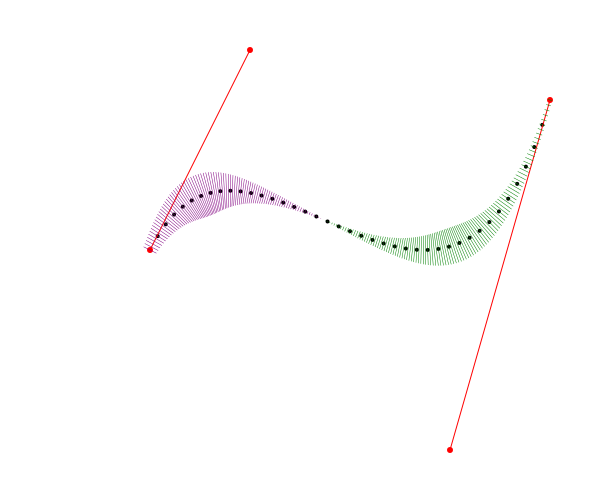

In [23]:
@png begin
    p1  = Point(-150, 0)
    cp1 = Point(-50, -200)
    cp2 = Point(150, 200)
    p2  = Point(250, -150)
    setline(0.1)
    for u in 0:0.025:1
        pt = bezier(u, p1, cp1, cp2, p2)
        circle(pt, 2, :fill)
    end
    sethue("red")
    circle.([p1, cp1, cp2, p2], 3, :fill)
    setline(1)
    line(p1, cp1, :stroke)
    line(p2, cp2, :stroke)
    sethue("black")
    fontsize(6)
    setline(0.5)
    drawcurvature(BezierPathSegment(p1, cp1, cp2, p2),
        scale=1500,
        stepby=0.005)
end 600 500 "images/bezier/drawcurvaturecomb.png"

![drawing the curvature comb](notebooks/images/bezier/drawcurvaturecomb.png)

Users of CAD systems (particularly industrial designers) like to display these *curvature combs* (in both 2D and 3D) to make sure that their shapes don't introduce noticeably abrupt (and possible weak) transitions. Type designers use them too, but as usual they like to let their eyes have the final say.

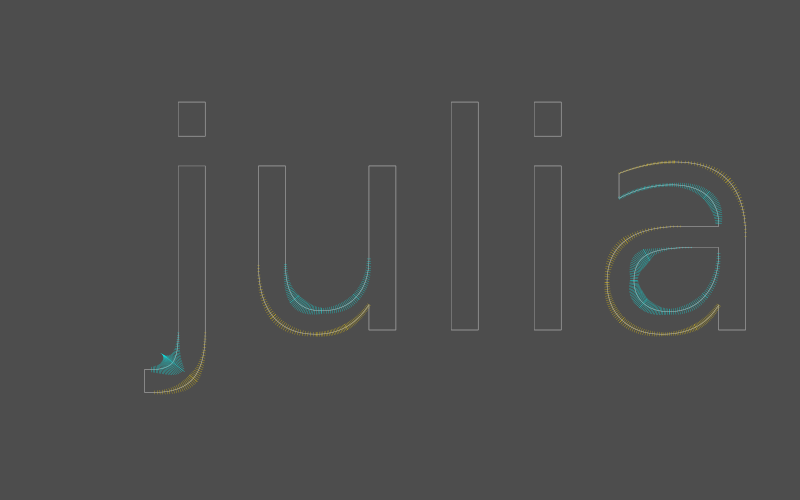

In [24]:
@png begin
    background("gray30")
    fontface("Times-BoldItalic")
    translate(-250, 80)
    fontsize(300)
    textpath("julia")
    bpaths = pathtobezierpaths()
    sethue("gray60")
    for bpath in bpaths
        for bpseg in bpath
            setline(0.5)
            drawbezierpath(bpseg, :stroke)
            setline(0.25)
            drawcurvature(bpseg,
                scale=180,
                stepby=0.05,
                colors=["gold", "cyan"])
        end
    end
end 800 500 "images/bezier/typecomb.png"

![curvature comb for the g](notebooks/images/bezier/typecomb.png)

The dots over the ‘i’ and ‘j’ don't look like perfect circles; these are defined by 8 points, not 4, for some reason.

### Osculate my Béziers

The value of kappa is typically very small, so the *radius of curvature*, which is defined as $$\frac{1}{kappa}$$, can become very large. This radius value defines a circle that just touches the curve and follows the curvature at that point. Mathematicians, in typically romantic mood, call it the *osculating circle*, *osculate* being from the Latin noun *osculum*, meaning "kiss".

Drawing osculating circles can be a challenge; they grow very large when the curve looks flat. To be honest it's a tricky diagram to style up, and there's a lot of information that it would be cool to keep and a shame to throw away. There's quite a bit of osculation going on here...

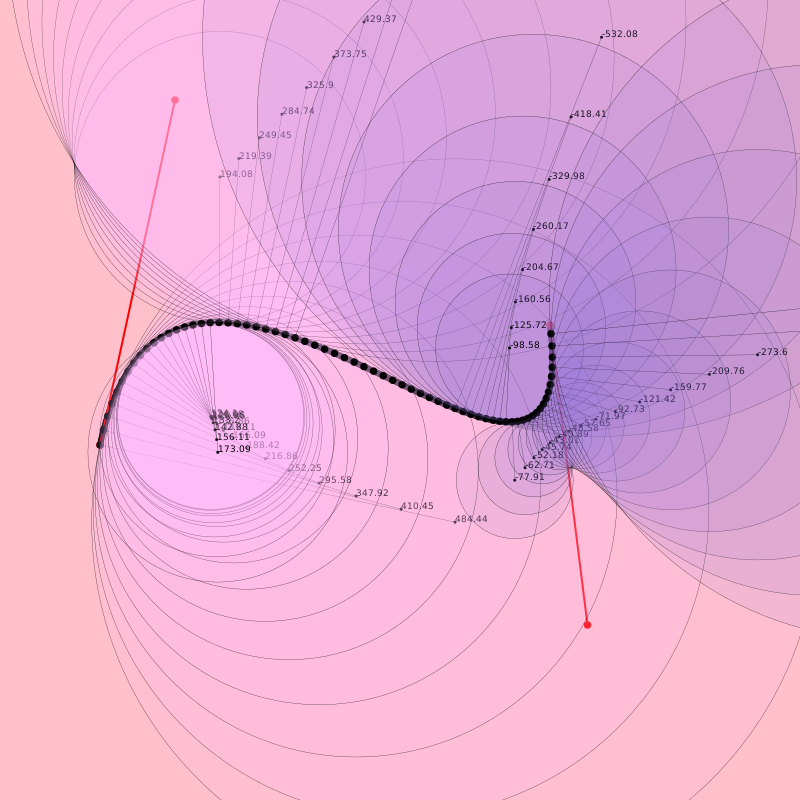

In [25]:
@png begin
    p1  = Point(-400, 60)
    cp1 = Point(-300, -400)
    cp2 = Point(250, 300)
    p2  = Point(200, -100)
    background("pink")
    scale(0.75)
    for u in 0:0.001:1
        pt = bezier(u, p1, cp1, cp2, p2)
        circle(pt, 4, :fill)
    end
    sethue("red")
    circle.([p1, cp1, cp2, p2], 5, :fill)
    setline(2)
    line(p1, cp1, :stroke)
    line(p2, cp2, :stroke)
    setopacity(0.1) ; setline(1.5) ; fontsize(5)
    for pointofcontact in 0.0:0.015:1.0
        kappa = beziercurvature(pointofcontact, p1, cp1, cp2, p2)
        pt = bezier(pointofcontact, p1, cp1, cp2, p2)
        @layer begin
            setopacity(1.0)
            sethue("black")
            circle(pt, 5, :fill)
        end
        pt1 = bezier′(pointofcontact, p1, cp1, cp2, p2)
        s = -1/(pt1.y/pt1.x) # normal is 1/slope
        radius = abs(1/kappa)
        centrepoint = pt + polar(radius, atan(s))
        if radius < 600
            sign(kappa) >= 0 ? sethue("plum1") : sethue("mediumpurple")
            circle(centrepoint, radius, :fill)
            @layer begin
                setopacity(1)
                setline(0.25)
                sethue("black")
                fontsize(12)
                circle(centrepoint, radius, :stroke)
                circle(centrepoint, 2, :fill)
                line(centrepoint, pt, :stroke)
                text(string(round(1/kappa, digits = 2)), centrepoint)
            end
        else
            text("too big", pt)
        end
    end
end 800 800 "images/bezier/osculate.png"

![osculating](notebooks/images/bezier/osculate.png)

## A blot on the landscape

Bézier curves became popular because they allow us to specify gently curving shapes that would be impractical and cumbersome to specify with circular arcs. The Comprehensive Taxonomy of Irregular Amoeboid Shapes is perhaps still waiting to be written, but here's my contribution to the ‘random ink blot’ chapter. Sometimes you'll get lucky and get a nice one.

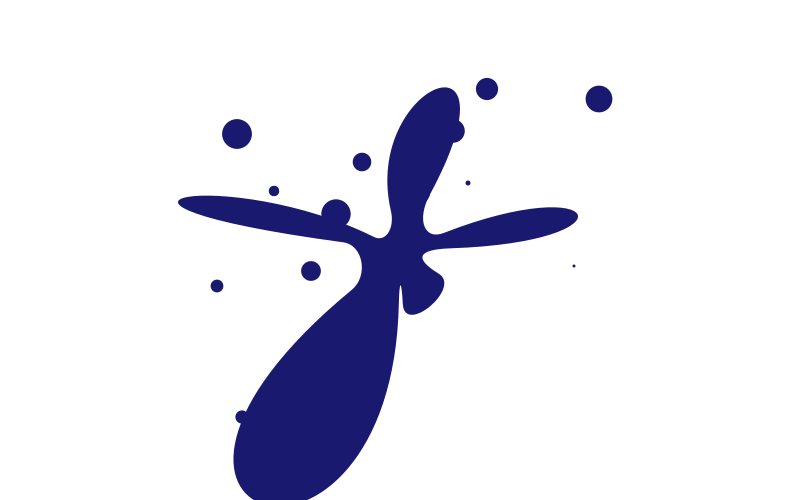

In [26]:
function blot(;pos=O, radius=50, npoints=10, action=:fill)
    center = pos
    pts = ngon(pos, radius, npoints, vertices=true)
    for i in 1:length(pts)
        pts[i] = pts[i] + (rand(-radius/3:radius/3), rand(-radius/3:radius/3))
    end
    bezpath = makebezierpath(pts)
    for n in 1:length(bezpath)
        bezseg = bezpath[mod1(n, length(bezpath))]
        if isodd(n)
            j = rand(1.4:0.1:7)
            bezseg.cp1 = between(center, bezseg.p1, j)
            bezseg.cp2 = between(center, bezseg.p2, j)
        else
            j = rand(0.25:0.1:0.7)
            bezseg.cp1 = between(center, bezseg.p1, j)
            bezseg.cp2 = between(center, bezseg.p2, j)
        end
    end
    drawbezierpath(bezpath, action)
    return bezpath
end

@png begin
    sethue("midnightblue")
    blot(npoints=10)
    circle.([Point(rand(-200:200), rand(-200:200)) for i in 1:15], rand(1:0.1:15, 15), :fill)
end 800 500 "images/bezier/blot.png"

![blot](notebooks/images/bezier/blot.png)

The control handles of alternate points are positioned on a line from the center to the point.

You could analyse the curvature of these blobs, if you really wanted to, using the `drawcurvature()` function from earlier:

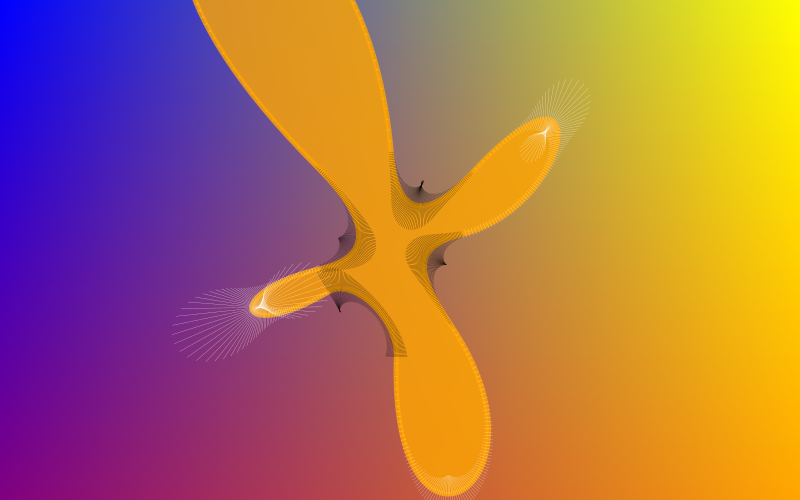

In [27]:
@png begin
    pl = box(BoundingBox(), vertices=true)
    mesh1 = mesh(pl, ["purple", "blue", "yellow", "orange"])
    setmesh(mesh1)
    paint()
    setopacity(0.8)
    sethue("orange")
    setline(5)
    b = blot(radius=80, npoints=8, action=:stroke)
    drawbezierpath(b, :fill)
    setline(.25)
    drawcurvature.(b, colors=["white", "black"])
end 800 500 "images/bezier/blobcomb.png"

![blob comb](notebooks/images/bezier/blobcomb.png)

## A brush in the rough

Not all lines generated by computers have to be rigidly straight and precise. What if we could easily make graphics that are a bit more relaxed in style, rather than the rigid CAD-like (and yes, awesome) precision graphics we're used to?

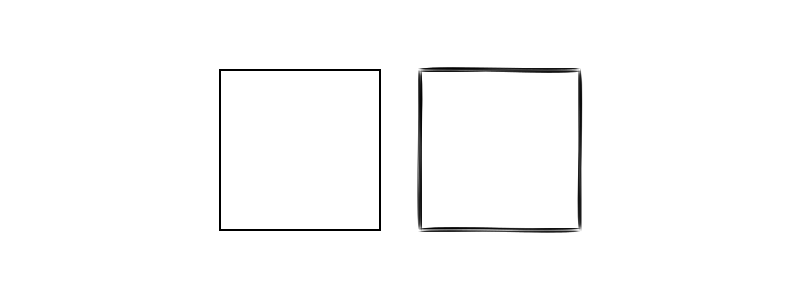

In [28]:
@png begin
    t = Table(1, 3)
    box(t[1], 160, 160, :stroke)
    boxv = box(t[3], 160, 160, vertices=true)
    foreach((f, t) ->
        brush(f, t, 3),
           boxv[1:4],
           boxv[mod1.(2:5, 4)])
end 800 300 "images/bezier/lines.png"

![rough lines](notebooks/images/bezier/lines.png)

## “A line is a breadthless length.” (Euclid)

The idea here is that a single line between two points is replaced with some BezierPathSegments that together define a shape that can vary in thickness along its length. This shape can be then filled, and is independent of the set line thickness.

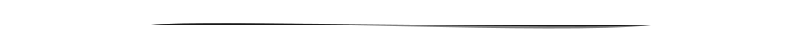

In [29]:
@png begin
    setline(60) # <— pointless
    brush(O - (250, 0), O + (250, 0), 4, strokes=1)
end 800 50  "images/bezier/brushline1.png"

![brush line](notebooks/images/bezier/brushline1.png)

The experimental `brush()` function is bristling with built-in randomness, so you never know what you're going to get. There are some control knobs available which you can play with.

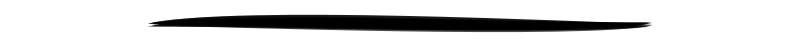

In [30]:
@png begin
    brush(O - (250, 0), O + (250, 0), 5,
        strokes=15,
        twist=4)
end 800 50  "images/bezier/brushline2.png"

![brush line 2](notebooks/images/bezier/brushline2.png)

To be honest, I think it's a bit daft to abandon the machine-like precision that our graphics software usually gives us for this variable hand-made look.

In [31]:
using IterTools
@png begin
    background("gray20")
    sethue("ivory")
    for ss in subsets(ngon(O, 250, 13, vertices=true), 2)
        # line(ss[1], ss[2], :stroke) # use this line for accurate graphics
        brush(ss[1], ss[2], 4,
            strokes=1,
            minwidth=0.001,
            maxwidth=0.05,
            lowhandle=0.1,
            highhandle=.2,
            randomopacity=true)
    end
end 800 600  "images/bezier/linepartition.png"

LoadError: ArgumentError: Package IterTools not found in current path:
- Run `import Pkg; Pkg.add("IterTools")` to install the IterTools package.


![line partition](notebooks/images/bezier/linepartition.png)

Today, our relationship with mechanical production and product design is inconsistent; some of the things we desire we want to be hand-made, but others we'd prefer to be machine-made. Only the most expensive cars claim to be made ‘by hand’; the cheaper models flaunt their nanometre precision instead. Hipsters seek the authentic analogue roughness of the products of the Second Industrial age, but are secretly grateful for and rely on the smooth precisions afforded by the Third. Handmade shoes yes, handmode iPhones, no.

There are a number of plotting packages that offer a hand-drawn aesthetic—[this site](http://xkcdgraphs.com) is web-based. So you can definitely announce your latest scientific discovery using XKCD-style presentation graphics. There are XKCD-styling kits for most of the software used by people who have heard of XKCD.

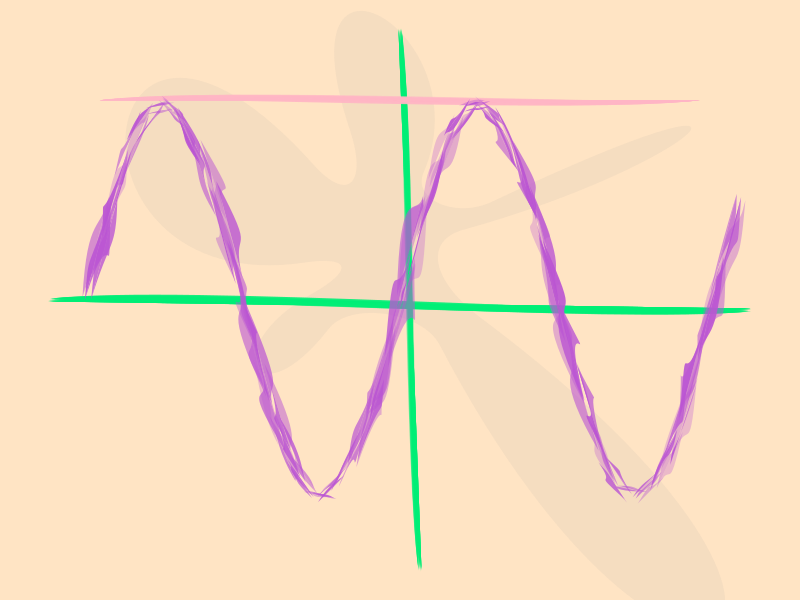

In [32]:
@png begin
    background("bisque")
    sethue("gray60")
    setopacity(0.1)
    blot(pos=O + (-10, -50), radius=100)
    sethue("springgreen2")
    brush(O + (20, 270), O + (0, -270), 3) # wonk y-axis
    brush(O - (350, 0), O + (350, 10), 3)  # wonk x-axis

    sine = [(Point(50x, -200sin(x)), Point(50(x + pi/6), -200sin(x + pi/6))) for x in -2pi:pi/10:2pi]

    sethue("pink1")
    brush(Point(-300, -200), Point(300, -200), 0.5)

    sethue("mediumorchid")
    foreach(pr -> brush(pr[1], pr[2], twist=5, highhandle=4, strokes=3), sine)
end 800 600 "images/bezier/graph.png"

![a graph](notebooks/images/bezier/graph.png)

Unfortunately you've got the imprecise finish *without* the reassuring and lovable hand-made quirks. Like those imitation hand-writing fonts, it's presenting the illusion of manual labour.

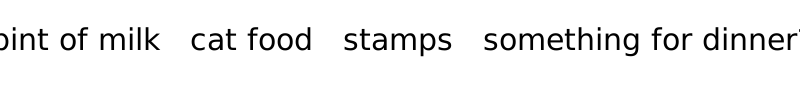

In [33]:
@png begin
    fontsize(30)
    fontface("SnellRoundhand-Script")
    text("pint of milk   cat food   stamps   something for dinner? ", halign=:center)
end 800 100 "images/bezier/shoppinglist.png"

![a shopping list](notebooks/images/bezier/shoppinglist.png)

## A fist full of brushes

But it's always fun to explore an idea to see where it leads:

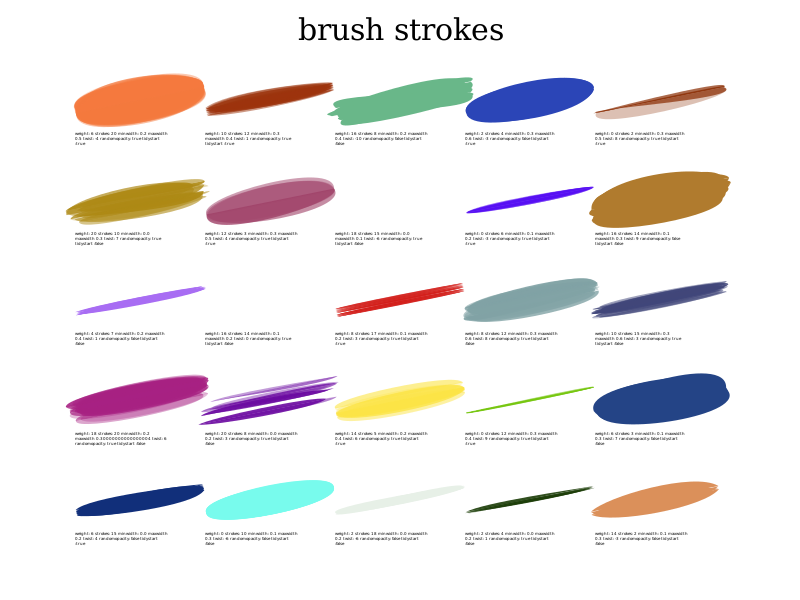

In [34]:
@png begin
    t = Table(5, 5, 130, 100)
    l = t.colwidths[1]
    fontsize(4)
    for (pos, n) in t
        weight = rand(0:2:20)
        strokes = rand(1:20)
        minwidth=rand(0.0:0.1:0.3)
        maxwidth=rand(minwidth+0.1:0.1:minwidth+0.3)
        twist = rand(-10:10)
        randomopacity = rand(Bool)
        lowhandle = rand(0.0:0.1:0.5)
        highhandle = rand(lowhandle:0.1:lowhandle+.5)
        tidystart = rand(Bool)
        @layer begin
            translate(pos)
            rotate(-0.2)
            randomhue()
            brush(O - (l/2, 0), O + (l/2, 0), weight,
                strokes=strokes,
                minwidth=minwidth,
                maxwidth=maxwidth,
                lowhandle=lowhandle,
                highhandle=highhandle,
                twist=twist,
                randomopacity=randomopacity,
                tidystart=tidystart)
        end

        textwrap("weight: $weight
            strokes: $strokes
            minwidth: $minwidth
            maxwidth $maxwidth
            twist: $twist
            randomopacity: $randomopacity
            tidystart :$tidystart", t.colwidths[1] - 30, pos + (-l/2, 30))
    end

    sethue("black")
    fontsize(30)
    fontface("Elephant")
    text("brush strokes", boxtop(BoundingBox()) + (0, 40), halign=:center)
end 800 600 "images/bezier/brushes.png"

![a catalog of brushes](notebooks/images/bezier/brushes.png)

The line quality can make for simple painterly graphics, good for the occasional [Bob Ross](https://en.wikipedia.org/wiki/Bob_Ross) painting:

In [35]:
using ColorSchemes
function drawsunset()
    colscheme= ColorSchemes.sunset
    @png begin
        background("burlywood4")
        sethue("orange")
        circle(O + (0, 60), 60, :fill)
        setopacity(0.5)
        for y in -200:20:180
            sethue(get(colscheme, rescale(y, -200, 180, 1, 0)))
            for w in 10:5:20
                brush(Point(-350, y), Point(350, y), w,
                    strokes = 1,
                    twist = 5,
                    minwidth=0.02,
                    maxwidth=0.04,
                    randomopacity=true
                )
            end
        end
        fontsize(30)
        fontface("Pique-Black")
        text("Sunset over Luxor", Point(0, 230), halign=:center)
    end 800 500 "images/bezier/sunset.png"
end
drawsunset()

LoadError: ArgumentError: Package ColorSchemes not found in current path:
- Run `import Pkg; Pkg.add("ColorSchemes")` to install the ColorSchemes package.


![sunset over luxor](notebooks/images/bezier/sunset.png)

Each time you evaluate this the result is slightly different, yet always the same. Perhaps the next one will be better — wait, no, perhaps I preferred the previous one...

And because we started in France, let's paint some graffiti:

In [36]:
function drawfrenchflag()
    w, h = 700, 400
    @png begin
        background("azure")
        setopacity(0.85)
        setline(0.5)
        colscheme = ColorScheme([Colors.RGB.(sethue("royalblue1")...),
                   Colors.RGB.(sethue("white")...),
                   Colors.RGB.(sethue("red")...)])
        for x in -w/2:40:w/2
            # reduce x to 1, 2, or 3, then to [0-1] to get red/white/blue
            col = rescale(div(x+w/2, w/3) + 1, 1, 3, 0, 1)
            sethue(get(colscheme, col))
            for i in 5:10:50
                brush(Point(x, -h/2), Point(x, h/2),
                    i,
                    strokes=2,
                    twist=10,
                    highhandle=1)
            end
        end
        b = box(O, 675, 375, vertices=true)
        for i in 1:length(b)
            sethue("purple")
            brush(b[i], b[mod1(i + 1, length(b))], 30,
                strokes=20,
                minwidth=0.01,
                maxwidth=0.05)
        end
        fontface("MistralStd")
        setopacity(0.7)
        sethue("purple")
        fontsize(100)
        text("Vive la France!", O + (10, 80), halign=:center, angle=-pi/10)
    end 800 500 "images/bezier/frenchflag.png"
end

drawfrenchflag()

LoadError: UndefVarError: ColorScheme not defined

![drapeau francais](notebooks/images/bezier/frenchflag.png)

...and then speed off in our curvaceous old Citroen DS and drive to the France/Swiss border, where CERN are busy recreating the big bang:

In [37]:
using ColorSchemes
function unpetitbang()
    @png begin
        background("gray10")

        # rays
        for i in 1:300
            sethue(get(ColorSchemes.inferno, rand()))
            rotate(rand())
            brush(O + (rand(30:500), 0), O + (rand(501:1000), 0), 1,
                strokes=5,
                twist=rand(-1:0.1:1),
                lowhandle  = 0.0,
                highhandle = 0.5
                )
            l = rand(100:600)
            l1 = l + rand(5:50)
            sethue("white")
            brush(O + (l, 0), O + (l1, 0), 1,
                strokes=10,
                twist=rand(-1:0.1:1),
                lowhandle  = 0.0,
                highhandle = 1
                )
        end

        # plasmas
        for i in 1:20
            sethue(get(ColorSchemes.plasma, rand()))
            setopacity(rand(0.25:.05:0.75))
            rotate(rand())
            brush(O - (20, 0), O + (20, 0), 20,
                maxwidth = 10,
                highhandle = 10)
        end

        # orbits
        sethue("ivory")
        setline(0.5)
        for i in 1:10
            rotate(rand())
            brush(O - (0, 0), O + (50, 0), 10,
                maxwidth = 20,
                highhandle = 20,
                action=:stroke)
        end

    end 1000 1000 "images/bezier/unpetitbang.png"
end
unpetitbang()

LoadError: ArgumentError: Package ColorSchemes not found in current path:
- Run `import Pkg; Pkg.add("ColorSchemes")` to install the ColorSchemes package.


![un petit bang](notebooks/images/bezier/unpetitbang.png)

[2018-06-20]

### Footnotes

#### *Don Lancaster*

Don Lancaster is the totally awesome dude who was active in the very early days of personal computing, and probably knows more about PostScript than most of the current Adobe Systems employees put together. Travel back in time by visiting his wacky website at http://www.tinaja.com.

#### *Graphic formats*

All the images in this post are in PNG, but they looked better in the vector-based SVG format. However, there's an annoying ‘bug’ in Jupyter/IJulia/IPython involving text in SVG images created by Cairo. What happens is that Cairo tries to be smart and stores text in XML symbols, suitable for re-use. A good idea, but unfortunately they're stored in the notebook's ‘global XML scope’, and so later cells accidentally pick up symbol definitions from earlier cells and re-use them, even though that's not always what you want. A solution would be to somehow encapsulate the SVG image in a cell to prevent the definitions leaking. I don't know how to do that yet, but there's an [open issue](https://github.com/JuliaLang/IJulia.jl/issues/662) if you can help me find a workround...

In [38]:
@show pwd()

pwd() = "/home/kdb/Documents/github/jupyter/julia/notebooks"


"/home/kdb/Documents/github/jupyter/julia/notebooks"

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*